**Business Undersanding**

Imagine driving through town and a coupon is delivered to your cell phone for a restaurant near where you are driving. Would you accept that coupon and take a short detour to the restaurant? Would you accept the coupon but use it on a subsequent trip? Would you ignore the coupon entirely? 
What if the coupon was for a bar instead of a restaurant? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?
Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?


**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \\$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\\$20 - $50).


**Import Libraries for Data Exploration**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
#load input data in pandas dataframe
data = pd.read_csv('data/coupons.csv')


In [3]:
data.head()


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [4]:
data.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [7]:
# write in output files the results of data exploration
data_head_file = "output_data/data_analysis/data_head_file.csv"
data_info_file = "output_data/data_analysis/data_info_file.txt"
data_isnull_file = "output_data/data_analysis/data_isnull_file.csv"

# get head of dataframe
data.head()
# convert dataframe to csv and write to a csv file
data.head().to_csv(data_head_file, index=False)

#redirect the output to a file using Python's StringIO class from the io module.
from io import StringIO
buffer = StringIO()
data.info(buf=buffer)
info_output = buffer.getvalue()

# Write to a file
with open(data_info_file, 'w') as f:
    f.write(info_output)

# data.isnull().sum() returns a Series, so you can write it to a file using to_csv. header=True gives the column name with number
data.isnull().sum().to_csv(data_isnull_file, header=True)

**Data Cleansing**

The income field has non-numeric values and it needs to be cleansed if we want to do any summary analysis. The "$" in values and "100000 or More" are converted to 100000.
The data is converted to numeric and any errorneous data are converted to NaN.

In [8]:
# Statistical Summaries - Goal: Identify factors that most influence coupon acceptance.
# Provide summaries of key statistics for customers who accepted vs rejected coupons:
# Average age, income, number of visits to bars/restaurants.
# Probability of acceptance based on features (conditional probabilities).

# Calculate average income for Y=1 vs Y=0
# the below command is not working because income column has non-numeric values e.g. $ sign and values like $100000 or More 
# income column needs to be cleansed

# Remove dollar signs and commas, then convert to numeric
data['income'] = data['income'].replace({'\$': '', ',': ''}, regex=True)

# Replace specific categories (e.g., '100000 or More' with a high value, like 100000)
data['income'] = data['income'].replace({'100000 or More': '100000'}, regex=False)

# Convert the 'income' column to numeric values (NaN for invalid data)
data['income'] = pd.to_numeric(data['income'], errors='coerce')

# Check if the conversion worked
print(data['income'].head())

# Now you can group and calculate the mean
avg_income_by_y = data.groupby('Y')['income'].mean()

# Print the result
print(avg_income_by_y)

bar_data = data[(data['coupon'] == 'Bar') & (data['passanger'] == 'Minor')]
acceptance_rate = bar_data['Y'].mean()
print(f"Acceptance rate for bar coupon with minor passenger: {acceptance_rate:.2f}")

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: income, dtype: float64
Y
0    100000.0
1    100000.0
Name: income, dtype: float64
Acceptance rate for bar coupon with minor passenger: nan


**Exploratory Data Analysis**

Each dependent variable and combined variables are plotted and the plots are saved in "output_data/plots" folder.
The "Y" column in data file is plotted against the dependent variables to find patterns:
- User Attribute Analysis e.g. age, gender
- Contextual analysis e.g. weather, weather temperature combined, passenger, time, pairplot to see many variables together.
- Coupon Attributes analysis e.g. coupon type, expiration

**User Atrribute Analysis**

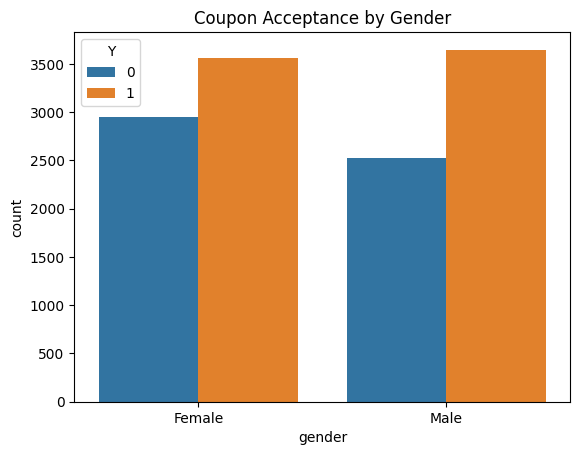

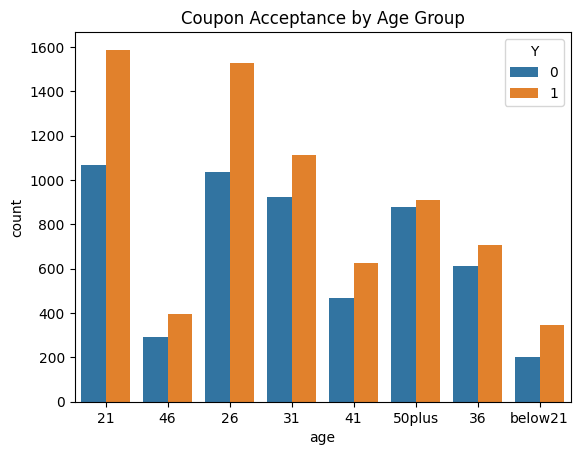

In [9]:
# User Atrribute Analysis using Seaborn python library
# plot acceptance by gender
# The hue parameter is used to group the data by another categorical variable, which is 'Y' in this case.
sns.countplot(x='gender', hue='Y', data=data)
plt.title("Coupon Acceptance by Gender")

# Save the plot as an image file. dpi=300: Sets the resolution of the image (higher DPI for better quality). 
# bbox_inches='tight': Ensures that the entire plot, including labels, is saved without clipping.
plt.savefig('output_data/plots/coupon_acceptance_by_gender.png', dpi=300, bbox_inches='tight')  # PNG file
plt.show()
# Plot acceptance by age group
sns.countplot(x='age', hue='Y', data=data)
plt.title("Coupon Acceptance by Age Group")
plt.savefig('output_data/plots/coupon_acceptance_by_age_group.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional - clear the plot
# plt.close()

**contextual analysis**

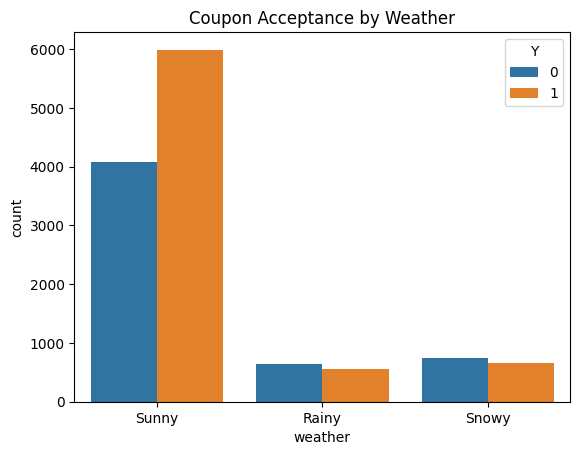

['Sunny - 55' 'Sunny - 80' 'Rainy - 55' 'Sunny - 30' 'Snowy - 30']


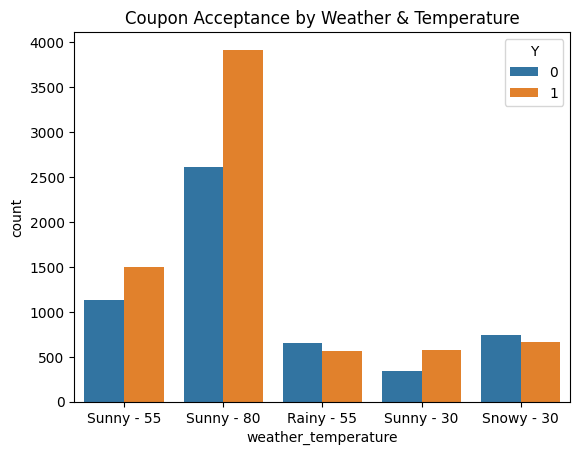

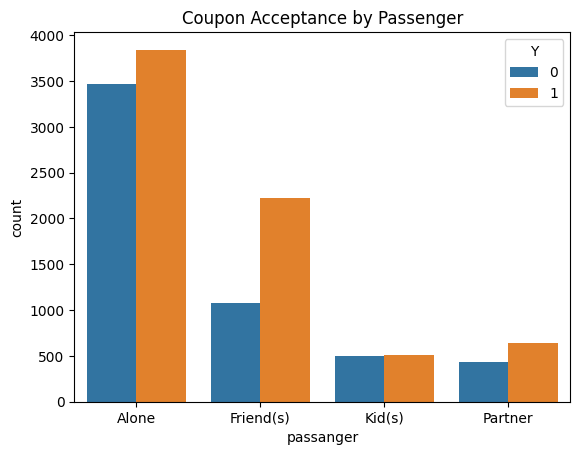

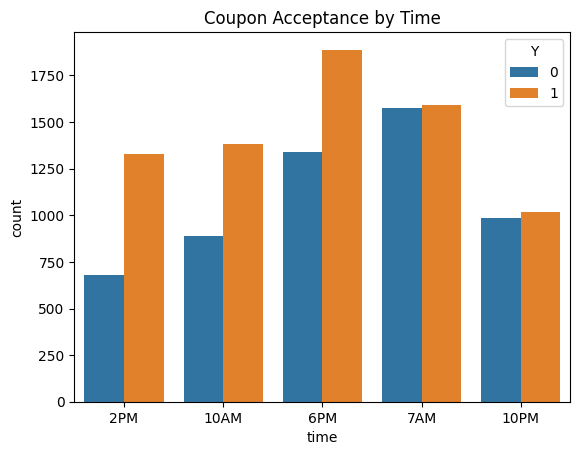

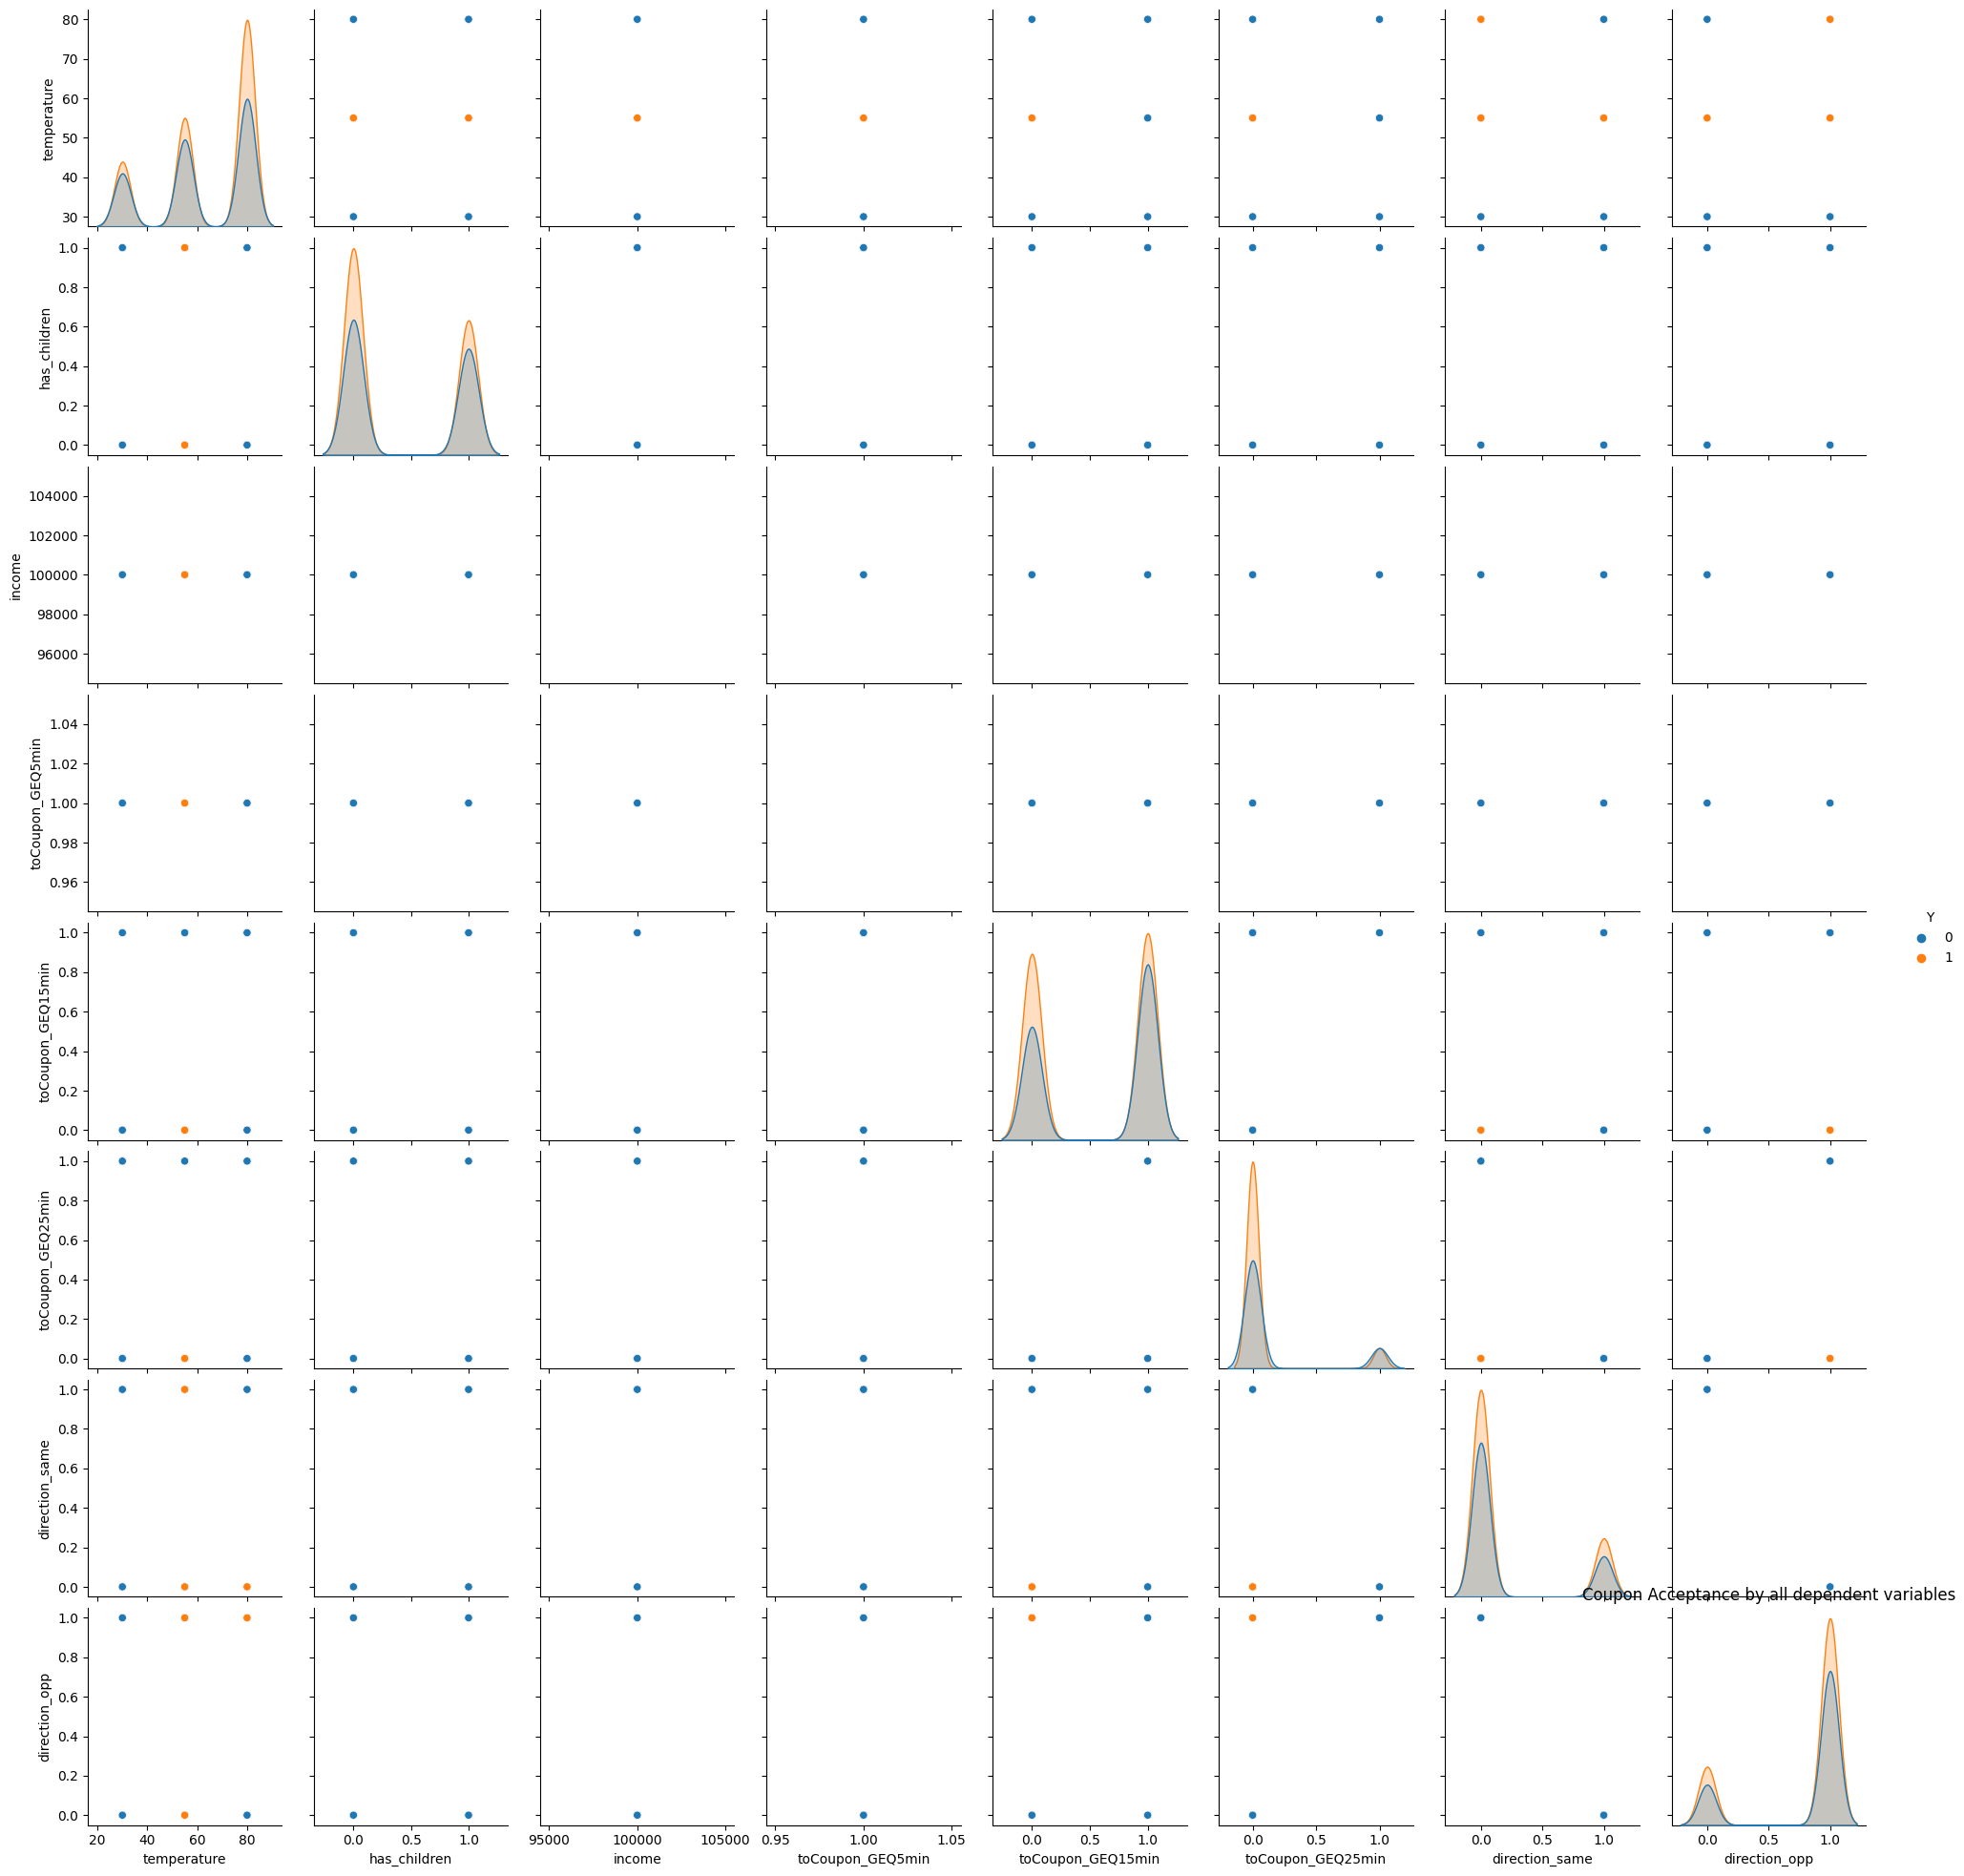

In [10]:
#contextual analysis
# Impact of weather on coupon acceptance
sns.countplot(x='weather', hue='Y', data=data)
plt.title("Coupon Acceptance by Weather")
plt.savefig('output_data/plots/coupon_acceptance_by_weather.png', dpi=300, bbox_inches='tight')
plt.show()

# Combine weather and temperature data and watch for impact
# Create a new column combining 'weather' and 'temperature'
data['weather_temperature'] = data['weather'] + ' - ' + data['temperature'].astype(str)
# Check the new combined column
print(data['weather_temperature'].unique())

sns.countplot(x='weather_temperature', hue='Y', data=data)
plt.title("Coupon Acceptance by Weather & Temperature")
plt.savefig('output_data/plots/coupon_acceptance_by_weather_temperature.png', dpi=300, bbox_inches='tight')
plt.show()

# Impact of passengers
sns.countplot(x='passanger', hue='Y', data=data)
plt.title("Coupon Acceptance by Passenger")
plt.savefig('output_data/plots/coupon_acceptance_by_passenger.png', dpi=300, bbox_inches='tight')
plt.show()

# Impact of time
sns.countplot(x='time', hue='Y', data=data)
plt.title("Coupon Acceptance by Time")
plt.savefig('output_data/plots/coupon_acceptance_by_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Pairplot to visualise the relationship between multiple variables
sns.pairplot(data, hue='Y')
plt.title("Coupon Acceptance by all dependent variables")
plt.savefig('output_data/plots/coupon_acceptance_by_all_vars.png', dpi=300, bbox_inches='tight')
plt.show()


**Coupon Attributes Analysis**

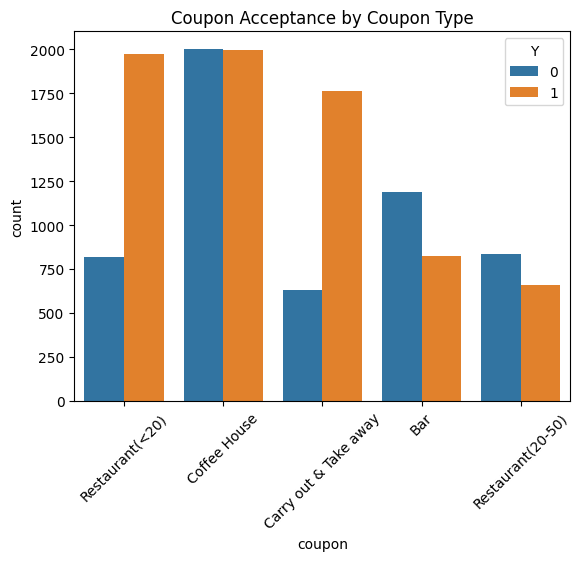

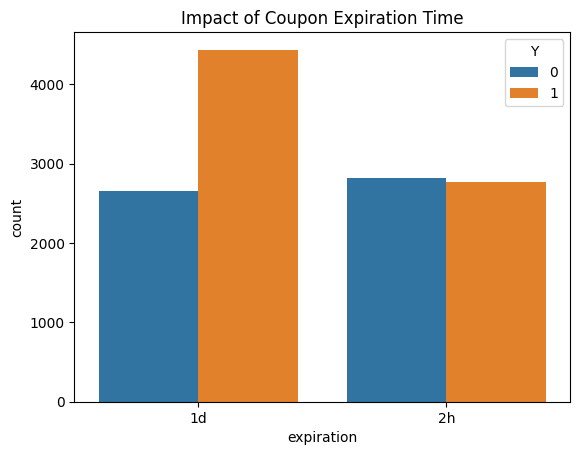

<Figure size 640x480 with 0 Axes>

In [11]:
# Coupon Attributes Analysis
# Acceptance by coupon type
sns.countplot(x='coupon', hue='Y', data=data)
plt.title("Coupon Acceptance by Coupon Type")
plt.xticks(rotation = 45)
plt.show()
plt.savefig('output_data/plots/coupon_acceptance_by_coupon_type.png', dpi=300, bbox_inches='tight')

# Impact of expiration time
sns.countplot(x='expiration', hue='Y', data=data)
plt.title("Impact of Coupon Expiration Time")

plt.show()
plt.savefig('output_data/plots/coupon_acceptance_by_expiration.png', dpi=300, bbox_inches='tight')

**Findings & Recommendations for increased coupon acceptances**

Here are the findings from the Exploratory Data Analysis and plots. Here are some factors that can increase acceptances.
- Coupons with 1 day expiration has higher chance of acceptance.
- Restaurant "less than $20" or "Carry Out" restaurants have higher chances of acceptance
- Sunny and warmer temperatures have higher rates of acceptance
- Drivers driving alone or with friends have accepted more
- Time 6 pm and 2 pm are more favorable to accept coupons by drivers

Above features impact on the coupon acceptance pattern. 

**Recommendations**

Next step is to build a model. A classification model can be used to predict "Y" based on features e.g. Logistic Regression.
Split the data into train and test data sets and train the model on the training set. 
